In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
%matplotlib inline

# Load data

In [69]:
items = pd.read_csv('./data/items.csv')
shops = pd.read_csv('./data/shops.csv')
item_cats = pd.read_csv('./data/item_categories.csv')
sales = pd.read_csv('./data/sales_train.csv.gz')
sample_subs = pd.read_csv('./data/sample_submission.csv.gz')
test = pd.read_csv('./data/test.csv.gz')

# EDA

In [70]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [71]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [72]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [73]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [74]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [75]:
sample_subs.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [76]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


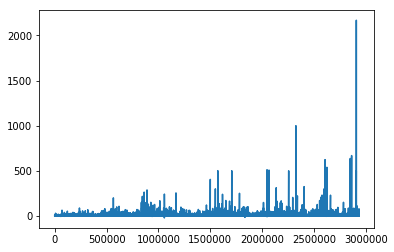

In [77]:
sales['item_cnt_day'].plot()

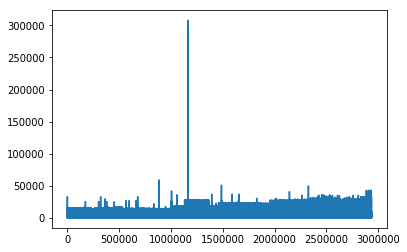

In [78]:
sales['item_price'].plot()

## Remove outliers

In [79]:
sales = sales[sales['item_price'] < 100000]
sales = sales[sales['item_cnt_day'] < 1000]

## Aggregate data

In [80]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# Compute all shop and item combinations
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [81]:
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


Transform the sales data to be grouped by month and fill missing data with 0

In [82]:
sales_in_month = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()

In [83]:
sales_in_month = pd.merge(grid, sales_in_month, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)

In [84]:
sales_in_month.rename({'item_cnt_day': 'item_cnt_month'}, axis='columns', inplace=True)

In [85]:
sales_in_month.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price
0,59,22154,0,1.0,999.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0


Add item info as well

In [86]:
sales_in_month = pd.merge(sales_in_month, items, on=['item_id'], how='left')

In [87]:
sales_in_month.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59


# Mean encoding

In [88]:
id_types = ['item_id', 'shop_id', 'item_category_id']
encoding_methods = [('item_price', np.mean, 'mean'), ('item_cnt_day', np.sum, 'sum'), ('item_cnt_day', np.mean, 'mean')]
sales_with_item_info = pd.merge(sales, items, on=['item_id'], how='left')

for id_type in id_types:
    for column_id, agg, agg_type in encoding_methods:
        new_df = sales_with_item_info.groupby([id_type, 'date_block_num']).aggregate(agg).reset_index()[[column_id, id_type, 'date_block_num']]
        new_df.columns = [id_type + '_' + agg_type + '_' + column_id, id_type, 'date_block_num']
        sales_in_month = pd.merge(sales_in_month, new_df, on=['date_block_num', id_type], how='left')

In [89]:
sales_in_month.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,item_id_mean_item_price,item_id_sum_item_cnt_day,item_id_mean_item_cnt_day,shop_id_mean_item_price,shop_id_sum_item_cnt_day,shop_id_mean_item_cnt_day,item_category_id_mean_item_price,item_category_id_sum_item_cnt_day,item_category_id_mean_item_cnt_day
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.00,18.0,1.0,820.174553,2017.0,1.092041,465.036007,6094.0,1.053414
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.00,0.0,0.0,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.05,1.0,1.0,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.85,2.0,1.0,820.174553,2017.0,1.092041,867.446992,268.0,1.007519
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.60,5.0,1.0,820.174553,2017.0,1.092041,443.330014,701.0,0.990113


In [90]:
sales_in_month.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_price',
       'item_name', 'item_category_id', 'item_id_mean_item_price',
       'item_id_sum_item_cnt_day', 'item_id_mean_item_cnt_day',
       'shop_id_mean_item_price', 'shop_id_sum_item_cnt_day',
       'shop_id_mean_item_cnt_day', 'item_category_id_mean_item_price',
       'item_category_id_sum_item_cnt_day',
       'item_category_id_mean_item_cnt_day'],
      dtype='object')

# Lag features

In [91]:
lag_features = ['item_id_mean_item_price',
 'item_id_sum_item_cnt_day',
 'item_id_mean_item_cnt_day',
 'shop_id_mean_item_price',
 'shop_id_sum_item_cnt_day',
 'shop_id_mean_item_cnt_day',
 'item_category_id_mean_item_price',
 'item_category_id_sum_item_cnt_day',
 'item_category_id_mean_item_cnt_day',
 'item_cnt_month']

In [92]:
lags = [1, 2, 3, 4, 6, 12]

In [93]:
for lag in lags:
    sales_lags = sales_in_month.copy()
    sales_lags.date_block_num += lag
    sales_lags = sales_lags[['date_block_num','shop_id','item_id'] + lag_features]
    sales_lags.columns = ['date_block_num','shop_id','item_id'] + [lag_feat + '_' + str(lag) + 'months_ago' for lag_feat in lag_variables]
    sales_in_month = pd.merge(sales_in_month, sales_lags, on=['date_block_num','shop_id','item_id'], how='left')


In [94]:
for feature in sales_in_month.columns:
    if 'item_cnt' in feature:
        sales_in_month[feature] = sales_in_month[feature].fillna(0)
    elif 'item_price' in feature:
        sales_in_month[feature] = sales_in_month[feature].fillna(sales_in_month[feature].median())

In [95]:
sales_in_month.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,item_id_mean_item_price,item_id_sum_item_cnt_day,item_id_mean_item_cnt_day,...,item_id_mean_item_price_12months_ago,item_id_sum_item_cnt_day_12months_ago,item_id_mean_item_cnt_day_12months_ago,shop_id_mean_item_price_12months_ago,shop_id_sum_item_cnt_day_12months_ago,shop_id_mean_item_cnt_day_12months_ago,item_category_id_mean_item_price_12months_ago,item_category_id_sum_item_cnt_day_12months_ago,item_category_id_mean_item_cnt_day_12months_ago,item_cnt_day_12months_ago
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.00,18.0,1.0,...,299.0,0.0,0.0,802.975375,0.0,0.0,359.712579,0.0,0.0,0.0
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.00,0.0,0.0,...,299.0,0.0,0.0,802.975375,0.0,0.0,359.712579,0.0,0.0,0.0
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.05,1.0,1.0,...,299.0,0.0,0.0,802.975375,0.0,0.0,359.712579,0.0,0.0,0.0
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.85,2.0,1.0,...,299.0,0.0,0.0,802.975375,0.0,0.0,359.712579,0.0,0.0,0.0
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.60,5.0,1.0,...,299.0,0.0,0.0,802.975375,0.0,0.0,359.712579,0.0,0.0,0.0


In [96]:
sales_in_month.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_price',
       'item_name', 'item_category_id', 'item_id_mean_item_price',
       'item_id_sum_item_cnt_day', 'item_id_mean_item_cnt_day',
       'shop_id_mean_item_price', 'shop_id_sum_item_cnt_day',
       'shop_id_mean_item_cnt_day', 'item_category_id_mean_item_price',
       'item_category_id_sum_item_cnt_day',
       'item_category_id_mean_item_cnt_day',
       'item_id_mean_item_price_1months_ago',
       'item_id_sum_item_cnt_day_1months_ago',
       'item_id_mean_item_cnt_day_1months_ago',
       'shop_id_mean_item_price_1months_ago',
       'shop_id_sum_item_cnt_day_1months_ago',
       'shop_id_mean_item_cnt_day_1months_ago',
       'item_category_id_mean_item_price_1months_ago',
       'item_category_id_sum_item_cnt_day_1months_ago',
       'item_category_id_mean_item_cnt_day_1months_ago',
       'item_cnt_day_1months_ago', 'item_id_mean_item_price_2months_ago',
       'item_id_sum_item_cnt_day_2months_ag

Only take recent data

In [97]:
sales_in_month = sales_in_month[sales_in_month['date_block_num'] > 12]

Drop some columns

In [102]:
unused_cols = lag_features[:-1] + ['item_name']

Clipping target values

In [103]:
sales_in_month['item_cnt_month'] = sales_in_month['item_cnt_month'].clip(0, 20)

# Split into training and validation sets

In [104]:
X_train = sales_in_month[sales_in_month['date_block_num'] < 33].drop(unused_cols, axis=1)
X_cv = sales_in_month[sales_in_month['date_block_num'] == 33].drop(unused_cols, axis=1)

In [105]:
X_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_category_id,item_id_mean_item_price_1months_ago,item_id_sum_item_cnt_day_1months_ago,item_id_mean_item_cnt_day_1months_ago,shop_id_mean_item_price_1months_ago,...,item_id_mean_item_price_12months_ago,item_id_sum_item_cnt_day_12months_ago,item_id_mean_item_cnt_day_12months_ago,shop_id_mean_item_price_12months_ago,shop_id_sum_item_cnt_day_12months_ago,shop_id_mean_item_cnt_day_12months_ago,item_category_id_mean_item_price_12months_ago,item_category_id_sum_item_cnt_day_12months_ago,item_category_id_mean_item_cnt_day_12months_ago,item_cnt_day_12months_ago
4836056,27,15242,13,2.0,699.0,63,670.333333,9.0,1.000000,933.352539,...,299.0,0.0,0.0,802.975375,0.0,0.000000,359.712579,0.0,0.000000,0.0
4836057,27,15200,13,1.0,299.0,69,499.000000,1.0,1.000000,933.352539,...,299.0,0.0,0.0,802.975375,0.0,0.000000,359.712579,0.0,0.000000,0.0
4836058,27,15279,13,2.0,799.0,63,798.112222,48.0,1.066667,933.352539,...,299.0,0.0,0.0,802.975375,0.0,0.000000,359.712579,0.0,0.000000,0.0
4836059,27,15202,13,1.0,299.0,69,499.000000,2.0,1.000000,933.352539,...,499.0,5.0,1.0,820.297558,4546.0,1.206155,703.047327,503.0,1.120267,0.0
4836060,27,14888,13,1.0,549.0,55,549.000000,21.0,1.000000,933.352539,...,299.0,0.0,0.0,802.975375,0.0,0.000000,359.712579,0.0,0.000000,0.0


In [106]:
X_train.to_csv('./data/X_train.csv', index=False)
X_cv.to_csv('./data/X_cv.csv', index=False)

In [107]:
import xgboost as xgb